In [3]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('bitcoin.csv')
df.head()

,cryptoName,date,open,close,high,low,average,volume,trade_count,vwap,timestamp
0,BTC/USD,02/05/2021,37102.75,39051.00,39699.95,37070.01,38384.980,1153.670297,55838.0,38439.087793,2021-02-05 06:00:00+00:00
1,BTC/USD,02/06/2021,39054.20,38571.85,41019.93,38000.00,39509.965,1238.672877,63997.0,39759.608536,2021-02-06 06:00:00+00:00
2,BTC/USD,02/07/2021,38565.36,38700.00,39736.17,37383.51,38559.840,932.225474,46244.0,38455.814609,2021-02-07 06:00:00+00:00
3,BTC/USD,02/08/2021,38712.80,46964.37,47500.00,38658.96,43079.480,2876.161989,91292.0,44010.764310,2021-02-08 06:00:00+00:00
4,BTC/USD,02/09/2021,46957.60,46166.35,48203.13,45040.00,46621.565,1420.610386,59671.0,46688.885698,2021-02-09 06:00:00+00:00


In [5]:
series = df['average'].values.reshape(len(df), 1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(series)

In [6]:
import math
train_size = math.floor((len(scaled_data) - 60) * 0.8)
X_train = []
y_train = []
for i in range(60, 60 + train_size):
  X_train.append(scaled_data[i-60:i, 0])
  y_train.append(scaled_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [8]:
X_train.shape

(515, 60, 1)

In [9]:
X_test = []
y_test = []
for i in range(60 + train_size, len(scaled_data)):
  X_test.append(scaled_data[i-60:i, 0])
  y_test.append(scaled_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [10]:
X_test.shape

(129, 60, 1)

In [11]:
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))

model_1.compile(optimizer='adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=10)

2024-05-15 14:11:18.516428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-15 14:11:18.516995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-15 14:11:18.517536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-15 14:11:18.566918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-05-15 14:11:18.566960: W tensorflow/core/common_runtime/gpu/g

Epoch 1/10
515/515 [==============================] - 11s 18ms/step - loss: 0.0085
Epoch 2/10
515/515 [==============================] - 9s 18ms/step - loss: 0.0038
Epoch 3/10
515/515 [==============================] - 9s 18ms/step - loss: 0.0031
Epoch 4/10
515/515 [==============================] - 9s 18ms/step - loss: 0.0030
Epoch 5/10
515/515 [==============================] - 10s 18ms/step - loss: 0.0027
Epoch 6/10
515/515 [==============================] - 9s 18ms/step - loss: 0.0028
Epoch 7/10
515/515 [==============================] - 9s 18ms/step - loss: 0.0028
Epoch 8/10
515/515 [==============================] - 9s 18ms/step - loss: 0.0024
Epoch 9/10
515/515 [==============================] - 9s 18ms/step - loss: 0.0020
Epoch 10/10
515/515 [==============================] - 9s 18ms/step - loss: 0.0020


In [12]:
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
len(predictions_1)

5/5 [==============================] - 1s 11ms/step


129

In [13]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
rmse = mse(df['average'][60 + train_size:], predictions_1, squared=False)
rmse

1602.5854948754431

Text(0.5, 0, 'epochs')

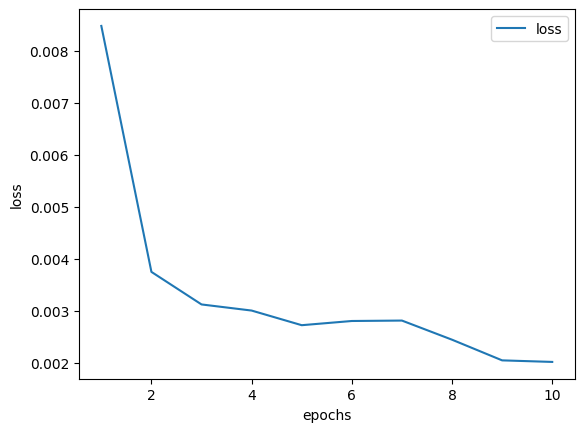

In [14]:
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [15]:
# Train the model again with 7 epochs
# but first we need to create another model so we can compare them together

# building LSTM model_2
tf.random.set_seed(42)

model_2 = Sequential()
model_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) | the simple form is "input_shape(60, 1)
model_2.add(LSTM(50, return_sequences=False))
model_2.add(Dense(25))
model_2.add(Dense(1))

# Compile model_2
model_2.compile(optimizer='Adam', loss='mse')

# Fit model_2
history_2 = model_2.fit(X_train, y_train, batch_size=1, epochs=6)

Epoch 1/6
515/515 [==============================] - 11s 19ms/step - loss: 0.0101
Epoch 2/6
515/515 [==============================] - 9s 18ms/step - loss: 0.0041
Epoch 3/6
515/515 [==============================] - 9s 18ms/step - loss: 0.0034
Epoch 4/6
515/515 [==============================] - 10s 18ms/step - loss: 0.0031
Epoch 5/6
515/515 [==============================] - 10s 19ms/step - loss: 0.0028
Epoch 6/6
515/515 [==============================] - 10s 19ms/step - loss: 0.0028


In [16]:
# Get the model_2 predicted price values
predictions_2 = model_2.predict(X_test)
predictions_2 = scaler.inverse_transform(predictions_2)
len(predictions_2)

5/5 [==============================] - 0s 11ms/step


129

In [17]:
# Get the root mean squared error (RMSE) for model_2
rmse_2 = mse(df['average'][60 + train_size:], predictions_2, squared=False)
rmse_2

563.7594312949194

/home/rxwangtw/miniconda3/envs/deepchem/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/rxwangtw/miniconda3/envs/deepchem/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


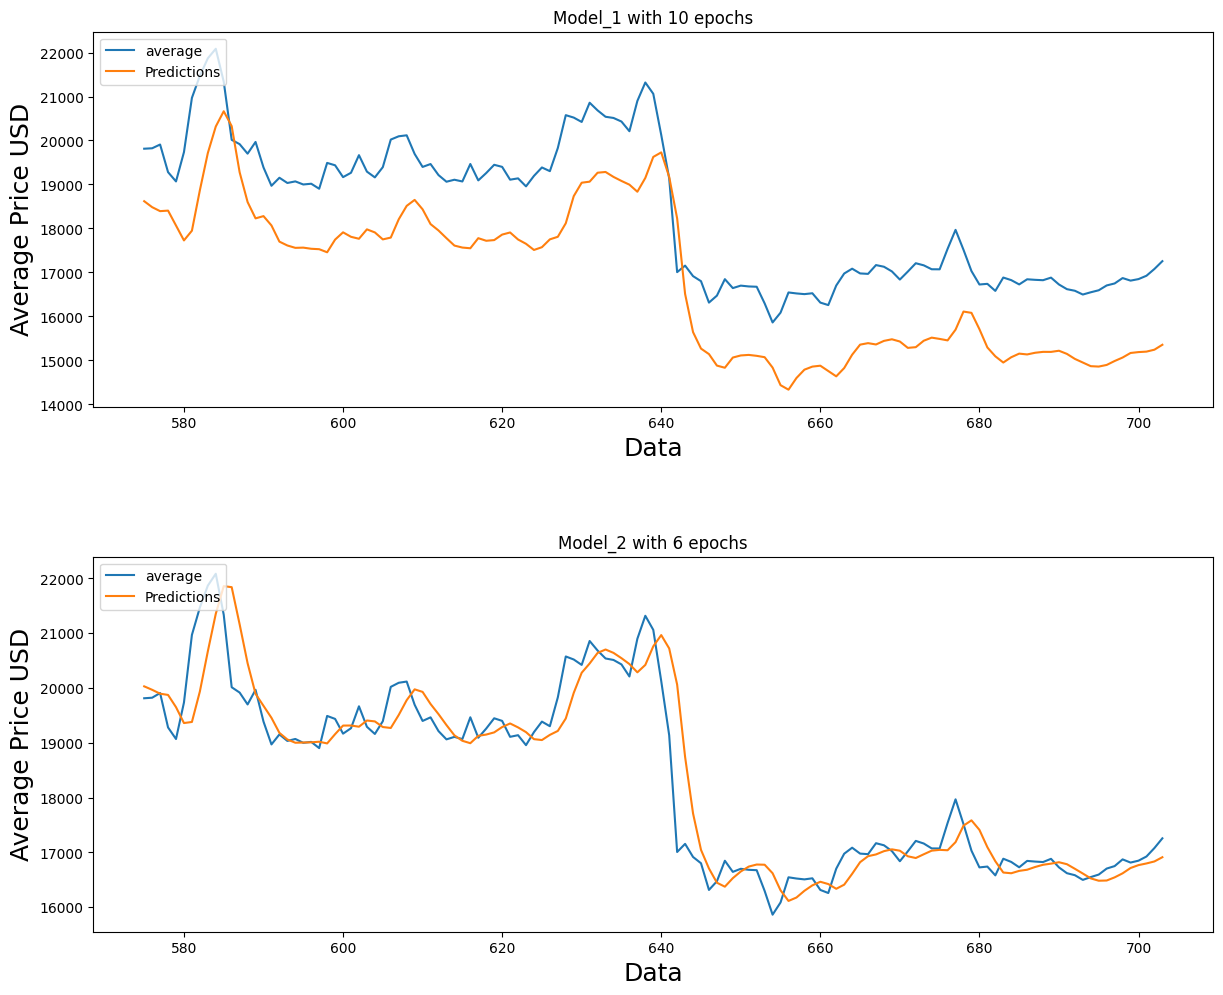

In [18]:
# Plot the data
train = df[60:60 + train_size]

#data for model_1
valid_1 = df[60 + train_size:]
valid_1['Predictions'] = predictions_1

# data for model_2
valid_2 = df[60 + train_size:]
valid_2['Predictions'] = predictions_2

# Visualized the data
#model_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Average Price USD', fontsize=18)
plt.plot(valid_1[['average', 'Predictions']])

plt.legend(['average', 'Predictions'], loc='upper left')

#model_2
plt.subplot(2, 1, 2)
plt.title('Model_2 with 6 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Average Price USD', fontsize=18)
plt.plot(valid_2[['average', 'Predictions']])

plt.legend(['average', 'Predictions'], loc='upper left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

# Sentiment model

In [20]:
interpolated_df = pd.read_csv('updated_interpolated_sentiment.csv')
score_series = interpolated_df['compoundScore'].values.reshape(len(interpolated_df), 1)
score_scaler = MinMaxScaler(feature_range=(0,1))
scaled_score = score_scaler.fit_transform(score_series)

In [21]:
X_train_sentiment = []
for i in range(60, 60 + train_size):
  X_train_sentiment.append(scaled_score[i-60:i, 0])
X_train_sentiment = np.array(X_train_sentiment)
X_train_sentiment = np.reshape(X_train_sentiment, (X_train_sentiment.shape[0], X_train_sentiment.shape[1], 1))

X_train = np.concatenate((X_train, X_train_sentiment), axis=2)

print(X_train.shape)
print(y_train.shape)

(515, 60, 2)
(515,)


In [22]:
tf.random.set_seed(42)

model_3 = Sequential()
model_3.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model_3.add(LSTM(50, return_sequences=False))
model_3.add(Dense(25))
model_3.add(Dense(1))

model_3.compile(optimizer='adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_3.fit(X_train, y_train, batch_size=1, epochs=10)



Epoch 1/10
515/515 [==============================] - 11s 18ms/step - loss: 0.0095
Epoch 2/10
515/515 [==============================] - 10s 19ms/step - loss: 0.0044
Epoch 3/10
515/515 [==============================] - 10s 18ms/step - loss: 0.0035
Epoch 4/10
515/515 [==============================] - 10s 19ms/step - loss: 0.0032
Epoch 5/10
515/515 [==============================] - 10s 19ms/step - loss: 0.0031
Epoch 6/10
515/515 [==============================] - 10s 19ms/step - loss: 0.0029
Epoch 7/10
515/515 [==============================] - 9s 18ms/step - loss: 0.0030
Epoch 8/10
515/515 [==============================] - 10s 19ms/step - loss: 0.0026
Epoch 9/10
515/515 [==============================] - 10s 19ms/step - loss: 0.0022
Epoch 10/10
515/515 [==============================] - 10s 19ms/step - loss: 0.0021


In [23]:
X_test_sentiment = []
for i in range(60+train_size, len(scaled_score)):
  X_test_sentiment.append(scaled_score[i-60:i, 0])
X_test_sentiment = np.array(X_test_sentiment)
X_test_sentiment = np.reshape(X_test_sentiment, (X_test_sentiment.shape[0], X_test_sentiment.shape[1], 1))

X_test = np.concatenate((X_test, X_test_sentiment), axis=2)

print(X_test.shape)
print(y_test.shape)

(129, 60, 2)
(129,)


In [24]:
predictions_3 = model_3.predict(X_test)

5/5 [==============================] - 1s 14ms/step


In [25]:
cryptoprice_predicted = scaler.inverse_transform(predictions_3[:, :1])
rmse = mse(df['average'][60+train_size:], cryptoprice_predicted, squared=False)
rmse

1407.4040632561541

Text(0.5, 0, 'epochs')

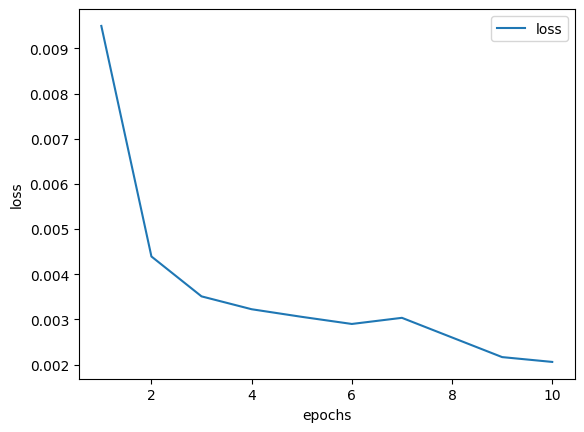

In [26]:
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

/home/rxwangtw/miniconda3/envs/deepchem/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rxwangtw/miniconda3/envs/deepchem/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


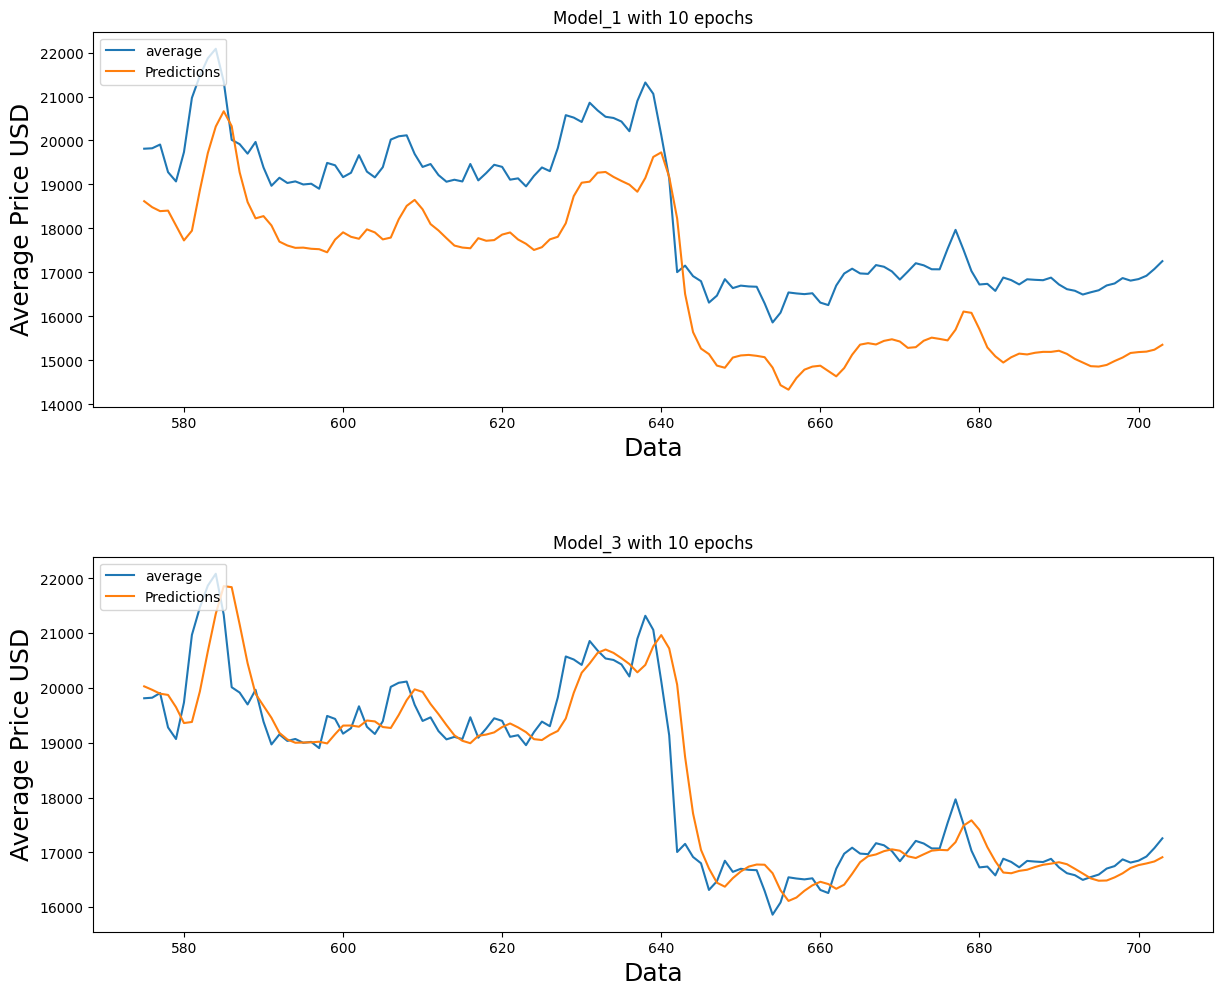

In [27]:

#data for model_1
valid_1 = df[60+train_size:]
valid_1['Predictions'] = predictions_1

# data for model_2
valid_3 = df[60+train_size:]
valid_3['Predictions'] = predictions_3

# Visualized the data
#model_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Average Price USD', fontsize=18)
plt.plot(valid_1[['average', 'Predictions']])

plt.legend(['average', 'Predictions'], loc='upper left')

#model_3
plt.subplot(2, 1, 2)
plt.title('Model_3 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Average Price USD', fontsize=18)
plt.plot(valid_2[['average', 'Predictions']])

plt.legend(['average', 'Predictions'], loc='upper left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
plt.show()